In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import sys 
sys.path.append("../../")
from src.model import ddsm as ddsm
from src.model import ddsm_model as modeld
from src.model.lightning_model_diffusion import LightningDiffusion as lightning_dif

import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
import wandb # This is optional 
wandb.login(host = "https://genentech.wandb.io" )


/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: uehara-masatoshi. Use `wandb login --relogin` to force relogin


True

# Load Pre-trained Model 

In [3]:
run = wandb.init(entity ='grelu', project="Diffusion-RNA", name = "test") # Change depending on your projects
artifact = run.use_artifact('UTR-Unconditional-Model:v0')
dir = artifact.download()
wandb.finish()

wandb: Currently logged in as: uehara-masatoshi (grelu). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact UTR-Unconditional-Model:v0, 152.04MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


In [2]:
class ModelParameters:
    diffusion_weights_file = 'artifacts/RNA-MPRA-dataset:v1/steps400.cat4.speed_balance.time4.0.samples100000.pth'
    time_schedule = "artifacts/RNA-MPRA-dataset:v1/time_dependent.npz"
    checkpoint_path = 'artifacts/UTR-Unconditional-Model:v0/diffusion_epoch=075.ckpt'
    
config = ModelParameters() 
DEVICE = "cuda:7" # Any number is fine

In [3]:
# Introduce Two Models
score_model = lightning_dif.load_from_checkpoint(checkpoint_path= config.checkpoint_path, weight_file = config.diffusion_weights_file, time_schedule = config.time_schedule, all_class_number =1)
score_model = score_model.model
score_model.cuda(device = DEVICE) 


original_model = lightning_dif.load_from_checkpoint(checkpoint_path= config.checkpoint_path, weight_file = config.diffusion_weights_file, time_schedule = config.time_schedule, all_class_number =1)
original_model = original_model.model
original_model.cuda(device = DEVICE) 

ScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (12

In [4]:
# Load Reward model
from grelu.lightning import LightningModel
model = LightningModel.load_from_checkpoint("artifacts/model:v7/model.ckpt")
model.eval()
model.to(DEVICE)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [5]:
def new_reward_model(x):
    x = torch.nn.functional.softmax(x /0.1, -1)
    seq = torch.transpose(x, 1, 2) 
    return model(seq)


## Start Fine-Tuning Diffusion Models 

In [6]:
from src.model import ddsm_fine_tune  as fine_tune

save_name = "log_MPRA/" # Set by yourself

loss_curves, eval_curves = fine_tune.fine_tuning(score_model, new_reward_model, [new_reward_model], original_model,
            learning_rate =1e-3, num_epoch = 1000, length = 50, num_steps = 50, accmu = 4, gradient_start = 45, \
            batch_size = 128, save_name = save_name, entropy_coff = 0.0,  device= DEVICE)

100%|██████████| 50/50 [00:00<00:00, 76.08it/s]


3


100%|██████████| 50/50 [00:01<00:00, 30.15it/s]


-0.036283139139413834
[-0.036283139139413834]


100%|██████████| 50/50 [00:00<00:00, 77.34it/s]


7


100%|██████████| 50/50 [00:01<00:00, 32.01it/s]


-0.03834335878491402
[-0.03834335878491402]


 78%|███████▊  | 39/50 [00:00<00:00, 81.52it/s]


KeyboardInterrupt: 

# Evaluation

In [6]:
#### Load Fine-Tuned Model 
time_dependent_weights = torch.tensor(np.load(config.time_schedule)['x'])
score_finetuned_model = modeld.ScoreNet(time_dependent_weights=torch.sqrt(time_dependent_weights)) 
score_finetuned_model.load_state_dict(torch.load("log_MPRA/_147.pth")) # Change here
score_finetuned_model.cuda(device = DEVICE) 


ScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (12

In [7]:
### Get Samples after Fine-tune models 

sampler = ddsm.Euler_Maruyama_sampler


allsamples_original = []
for t in range(5):
    samples=[]
    score_finetuned_model.eval()
    samples.append(sampler(score_finetuned_model,
                        (50,4),
                        batch_size=128,
                        new_class = None,
                        class_number = 1,
                        strength = 10, 
                        max_time=  4.0,
                        min_time= 1.0/400,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced= True,
                        device= DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original.append(samples)

100%|██████████| 100/100 [00:01<00:00, 58.74it/s]


In [8]:
allsamples = np.concatenate(allsamples_original, axis=1)
allsamples = allsamples[0,:,:,:]

generated_samples = []
data_loader = torch.utils.data.DataLoader(allsamples.astype("float32"), batch_size = 128 , num_workers=0)
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples.append(model(batch).detach().cpu() ) 

generated_samples = np.concatenate(generated_samples)

In [9]:
### Get Samples from Pre-Trained Models 

sampler = ddsm.Euler_Maruyama_sampler

allsamples_original = []
for t in range(5):
    samples=[]
    score_model.eval()
    samples.append(sampler(original_model,
                        (50,4),
                        batch_size=128,
                        new_class = None,
                        class_number = 1,
                        strength = 10, 
                        max_time=  4.0,
                        min_time= 1.0/400,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced= True,
                        device= DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original.append(samples)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 59.33it/s]


In [10]:
allsamples = np.concatenate(allsamples_original, axis=1)
allsamples = allsamples[0,:,:,:]

In [11]:
generated_samples_before = []
data_loader = torch.utils.data.DataLoader(allsamples.astype("float32"), batch_size = 128 , num_workers=0)
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples_before.append( model(batch).detach().cpu() ) 

In [12]:
generated_samples_before = np.concatenate(generated_samples_before)

<Figure size 8000x1000 with 0 Axes>

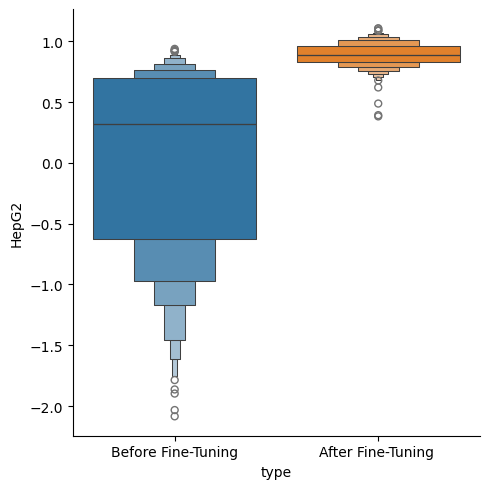

In [13]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(80, 10))

compare = np.concatenate( (generated_samples_before[:,0], generated_samples[:,0]  ), axis= 0)

type1 = ['Before Fine-Tuning' for i in range(len(generated_samples_before[:,0] ))]
#type2 = ['Generated (Strong Sig)' for i in range(len(generated_samples[:,0] ))]
type3 = ['After Fine-Tuning ' for i in range(len(generated_samples[:,0]))]

type =   type1 +  type3
data_dict = {'type': type, 'HepG2': compare[:,0] }
plot_data = pd.DataFrame(data_dict)
fig = sns.catplot(data=plot_data, x = 'type', y =  'HepG2', hue="type", kind="boxen" )
sns.set_context("paper", rc={"figure.figsize": (80, 10)})
#fig.savefig("../media/RNA_output_high.png")


